# 1. Getting Used to Handling Language Data

In [1]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

/Users/johnnybui/opt/miniconda3/envs/torch-mps/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset ag_news (/Users/johnnybui/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 52.71it/s]


In [ ]:
dataset['train']['text'][0:10]
# dataset

In [50]:
from collections import Counter 
from re import sub, compile
import matplotlib.pyplot as plt
import numpy as np

class UnimplementedFunctionError(Exception):
    pass

class Vocabulary:

    def __init__(self, corpus):

        self.word2idx, self.idx2word, self.freq = self.build_vocab(corpus)
        self.size = len(self.word2idx)

    def most_common(self, k):
        freq = sorted(self.freq.items(), key=lambda x: x[1], reverse=True)
        return [t for t,f in freq[:k]]


    def text2idx(self, text):
        tokens = self.tokenize(text)
        return [self.word2idx[t] if t in self.word2idx.keys() else self.word2idx['UNK'] for t in tokens]

    def idx2text(self, idxs):
        return [self.idx2word[i] if i in self.idx2word.keys() else 'UNK' for i in idxs]


    ###########################
    ## TASK 1.1                ##
    ###########################
    def tokenize(self, text):
        """
        
        tokenize takes in a string of text, remove punctuations and returns an 
        array of strings splitting the text into discrete tokens.

        :params: 
        - text: a string, e.g. "The blue dog jumped, but not high."

        :returns:
        - tokens: a list of strings derived from the text, e.g. ["the", "blue", 
        "dog", "jumped", "but", "not", "high"] for word-level tokenization
        
        """ 
        text = sub(r'[^\w\s]', '', text)
        return text.split()



    ###########################
    ## TASK 1.2                 ##
    ###########################
    def build_vocab(self,corpus):
        """
        
        build_vocab takes in list of strings corresponding to a text corpus, tokenizes the strings, and builds a finite vocabulary

        :params:
        - corpus: a list string to build a vocabulary over

        :returns: 
        - word2idx: a dictionary mapping token strings to their numerical index in the dictionary e.g. { "dog": 0, "but":1, ..., "UNK":129}
        - idx2word: the inverse of word2idx mapping an index in the vocabulary to its word e.g. {0: "dog", 1:"but", ..., 129:"UNK"}
        - freq: a dictionary of words and frequency counts over the corpus (including words not in the dictionary), e.g. {"dog":102, "the": 18023, ...}

        """ 
        word2idx = {}
        idx2word = {}
        freq = {}
        
        # Count tokens
        for s in corpus:
            for token in self.tokenize(s):
                if token not in freq.keys():
                    freq[token] = 1
                else:
                    freq[token] += 1
                    
        # Cutoff the tail
        cutoff = 50
        sorted_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
        
        word2idx["UNK"] = 0
        idx2word[0] = "UNK"
        id = 1   # Preserve 0 for UNK
        for (token,cnt) in sorted_freq:
            if cnt > 50:
                word2idx[token] = id
                idx2word[id] = token
                id += 1
            else:
                break
            
        
        return word2idx, idx2word, freq
    
    ###########################
    ## TASK 1.3              ##
    ###########################
    def make_vocab_charts(self):
        """
        
        make_vocab_charts plots word frequency and cumulative coverage charts 
        for this vocabulary. See handout for more details

        
        """ 
        cutoff = 50
        
        ax1 = plt.figure(figsize=(16,6))
        ax1 = plt.subplot(1,2,1)
        
        sorted_freq = self.most_common(len(self.freq))
        most_freq = [self.freq[k] for k in sorted_freq]
        
        cutoff_idx = -1
        occ_sum = sum(most_freq)
        cfc = [0]
        for i in range(len(most_freq)):
            if cutoff_idx == -1 and most_freq[i] < cutoff:
                cutoff_idx = i - 1
                
            cfc.append((cfc[-1] + most_freq[i] / occ_sum))
        
        ax1.plot(list(range(len(most_freq))), most_freq)
        ax1.axhline(y=cutoff, color='r')
        ax1.text(0.8*len(most_freq), cutoff * 1.2,"freq = %d" % cutoff)
        ax1.set_yscale("log")
        ax1.set_xlabel("Token ID (sorted by frequency)")
        ax1.set_xlabel("Frequency")
        ax1.set_title("Token Frequency Distribution")

        ax2 = plt.subplot(1,2,2)
        ax2.plot(list(range(len(cfc[1:]))), cfc[1:])
        ax2.axvline(x=cutoff_idx, color='r', label=str(most_freq[cutoff_idx]))
        ax2.text(1.2*cutoff_idx, 0.95*cfc[cutoff_idx], "%.02f" % cfc[cutoff_idx])
        plt.title("Cumulative Fraction Covered")
        plt.xlabel("Token ID (sorted by frequency)")
        plt.ylabel("Fraction of Token Occurences Covered")
        
        plt.savefig("Vocabulary.jpg")


In [51]:
vocab = Vocabulary(dataset['train']['text'])
vocab.text2idx("Bears are hug sdfsf e~~~~!!!")

[1959, 36, 0, 0, 0]

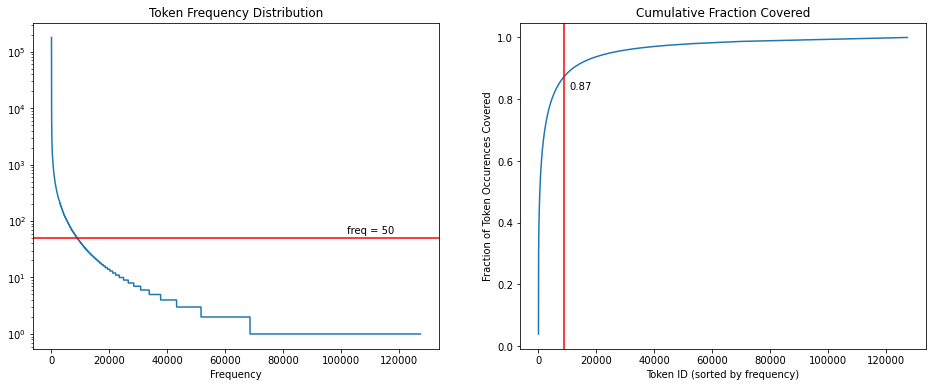

In [52]:
vocab.make_vocab_charts()

# 2. Frequency-Based Word Vectors - PPMI

In [ ]:

from datasets import load_dataset
from Vocabulary import Vocabulary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.utils.extmath import randomized_svd
import logging
import itertools
from sklearn.manifold import TSNE

import random
random.seed(42)
np.random.seed(42)

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

class UnimplementedFunctionError(Exception):
    pass


###########################
## TASK 2.2              ##
###########################

def compute_cooccurrence_matrix(corpus, vocab):
    """
        
        compute_cooccurrence_matrix takes in list of strings corresponding to a text corpus and a vocabulary of size N and returns 
        an N x N count matrix as described in the handout. It is up to the student to define the context of a word

        :params:
        - corpus: a list strings corresponding to a text corpus
        - vocab: a Vocabulary object derived from the corpus with N words

        :returns: 
        - C: a N x N matrix where the i,j'th entry is the co-occurrence frequency from the corpus between token i and j in the vocabulary

        """ 
    coor_matrix = np.ndarray()
    win_len = 10
    
    # Should be the entire sentence because they are well separated and quite "short". Need to check the max length though. But then one problem arises, 
    vocab.most_common()
    
    for i in sth:
        for j in sth:
            coor_freq[i][j] = 
    
    
    return coor_matrix
    

###########################
## TASK 2.3              ##
###########################

def compute_ppmi_matrix(corpus, vocab):
    """
        
        compute_ppmi_matrix takes in list of strings corresponding to a text corpus and a vocabulary of size N and returns 
        an N x N positive pointwise mutual information matrix as described in the handout. Use the compute_cooccurrence_matrix function. 

        :params:
        - corpus: a list strings corresponding to a text corpus
        - vocab: a Vocabulary object derived from the corpus with N words

        :returns: 
        - PPMI: a N x N matrix where the i,j'th entry is the estimated PPMI from the corpus between token i and j in the vocabulary

        """ 

    # REMOVE THIS ONCE YOU IMPLEMENT THIS FUNCTION
    raise UnimplementedFunctionError("You have not yet implemented compute_ppmi_matrix.")


    

################################################################################################
# Main Skeleton Code Driver
################################################################################################
def main_freq():

    logging.info("Loading dataset")
    dataset = load_dataset("ag_news")
    dataset_text =  [r['text'] for r in dataset['train']]
    dataset_labels = [r['label'] for r in dataset['train']]


    logging.info("Building vocabulary")
    vocab = Vocabulary(dataset_text)
    vocab.make_vocab_charts()
    plt.close()
    plt.pause(0.01)


    logging.info("Computing PPMI matrix")
    PPMI = compute_ppmi_matrix( [doc['text'] for doc in dataset['train']], vocab)


    logging.info("Performing Truncated SVD to reduce dimensionality")
    word_vectors = dim_reduce(PPMI)


    logging.info("Preparing T-SNE plot")
    plot_word_vectors_tsne(word_vectors, vocab)


def dim_reduce(PPMI, k=16):
    U, Sigma, VT = randomized_svd(PPMI, n_components=k, n_iter=10, random_state=42)
    SqrtSigma = np.sqrt(Sigma)[np.newaxis,:]

    U = U*SqrtSigma
    V = VT.T*SqrtSigma

    word_vectors = np.concatenate( (U, V), axis=1) 
    word_vectors = word_vectors / np.linalg.norm(word_vectors, axis=1)[:,np.newaxis]

    return word_vectors


def plot_word_vectors_tsne(word_vectors, vocab):
    coords = TSNE(metric="cosine", perplexity=50, random_state=42).fit_transform(word_vectors)

    plt.cla()
    top_word_idx = vocab.text2idx(" ".join(vocab.most_common(1000)))
    plt.plot(coords[top_word_idx,0], coords[top_word_idx,1], 'o', markerfacecolor='none', markeredgecolor='k', alpha=0.5, markersize=3)

    for i in tqdm(top_word_idx):
        plt.annotate(vocab.idx2text([i])[0],
            xy=(coords[i,0],coords[i,1]),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom',
            fontsize=5)
    plt.show()


# main_freq()
dataset

In [ ]:
vocab.most_common(50)

vocab.text2idx("asdf sadf saf saf sdaf")

# PPMI = compute_ppmi_matrix( [doc['text'] for doc in dataset['train']], vocab)

# 3. Learning-Based Word Vectors - GloVe

# 4. Exploring Learned Biases in word2vec Vectors